# Loading the Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
# If we want to run each section or not
GRIDSEARCH = False
TRAIN_TEST = False
SUBMIT = True

### Import datasets

In [3]:
folder_path = "dataset/"
train_x_file = "AMF_train_X_XCZw8r3.csv"
train_y_file = "AMF_train_Y_omYQJZL.csv"
test_x_file = "AMF_test_X_uDs0jHH.csv"
train_X = pd.read_csv(folder_path + train_x_file)
train_y = pd.read_csv(folder_path + train_y_file)
test_X = pd.read_csv(folder_path + test_x_file)

### Merge train data X and y

In [47]:
train_df = train_X.merge(train_y, on='Trader')

### Some visualization

In [48]:
train_df.head(5)

Index    Share      Day     Trader       OTR        OCR         OMR  \
0      1   Isin_8  Date_24  Trader_10  2.272727   8.333333   12.500000   
1      2  Isin_87  Date_29  Trader_10  1.696629  25.166667   21.571429   
2      3  Isin_87  Date_23  Trader_10  1.482759  47.300000  118.250000   
3      4  Isin_12  Date_11  Trader_10  1.705882  14.500000   29.000000   
4      5  Isin_87   Date_9  Trader_10  1.517730  26.750000         NaN   

   min_time_two_events  mean_time_two_events  10_p_time_two_events  ...  \
0                  0.0           5117.830300              0.000000  ...   
1                  0.0           1846.968401              0.000074  ...   
2                  0.0            686.300630              0.000071  ...   
3                  0.0           2174.335265              0.000000  ...   
4                  0.0            944.008551              0.000071  ...   

   mean_dt_TV1_TV2  med_dt_TV1_TV2  min_dt_TV1_TV3  mean_dt_TV1_TV3  \
0              NaN             NaN             NaN              NaN   
1              NaN             NaN             NaN              NaN   
2              NaN             NaN             NaN              NaN   
3              NaN             NaN             NaN              NaN   
4              NaN             NaN             NaN              NaN   

   med_dt_TV1_TV3  min_dt_TV1_TV4  mean_dt_TV1_TV4  med_dt_TV1_TV4  \
0             NaN             NaN              NaN             NaN   
1             NaN             NaN              NaN             NaN   
2             NaN             NaN              NaN             NaN   
3             NaN             NaN              NaN             NaN   
4             NaN             NaN              NaN             NaN   

   NbSecondWithAtLeatOneTrade     type  
0                           4  NON HFT  
1                          15  NON HFT  
2                          63  NON HFT  
3                           4  NON HFT  
4                          38  NON HFT  

[5 rows x 40 columns]

In [49]:
train_df.info(), train_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105782 entries, 0 to 105781
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Index                       105782 non-null  int64  
 1   Share                       105782 non-null  object 
 2   Day                         105782 non-null  object 
 3   Trader                      105782 non-null  object 
 4   OTR                         104099 non-null  float64
 5   OCR                         105782 non-null  float64
 6   OMR                         58170 non-null   float64
 7   min_time_two_events         105782 non-null  float64
 8   mean_time_two_events        105782 non-null  float64
 9   10_p_time_two_events        105782 non-null  float64
 10  med_time_two_events         105782 non-null  float64
 11  25_p_time_two_events        105782 non-null  float64
 12  75_p_time_two_events        105782 non-null  float64
 13  90_p_time_two_

(None, (105782, 40))

In [50]:
np.unique(train_df['type'], return_counts=True)

(array(['HFT', 'MIX', 'NON HFT'], dtype=object), array([31950, 51483, 22349]))

### Data Preprocessing

#### adding column difference med_dt_TV1_TV2/mean_dt_TV1_TV2

In [51]:
train_X['TV_mean_med_difference'] = train_X['med_dt_TV1']/train_X['mean_dt_TV1']
test_X['TV_mean_med_difference'] = test_X['med_dt_TV1']/test_X['mean_dt_TV1']

#### adding number of lines per trader

In [52]:
n_lines_train = train_X.groupby('Trader').count().Index
n_lines_test = test_X.groupby('Trader').count().Index

In [53]:
train_X = train_X.merge(n_lines_train, on='Trader',suffixes=('', '_number_of_lines'))
test_X = test_X.merge(n_lines_test, on='Trader',suffixes=('', '_number_of_lines'))

#### transforming the columns

In [54]:
log_cols = ['OCR','OTR','OMR','NbSecondWithAtLeatOneTrade','MaxNbTradesBySecond','MeanNbTradesBySecond','min_lifetime_cancel','mean_lifetime_cancel','med_time_two_events','TV_mean_med_difference','med_lifetime_cancel','med_dt_TV1_TV2','mean_dt_TV1_TV3', 'med_dt_TV1_TV3', 'med_dt_TV1_TV4','Index_number_of_lines']
log_plus_one_cols=['mean_dt_TV1','mean_dt_TV1_TV2','90_p_time_two_events','mean_time_two_events', '75_p_time_two_events','75_p_lifetime_cancel','90_p_lifetime_cancel','med_dt_TV1','mean_dt_TV1_TV4']
identity_cols=['NbTradeVenueMic','max_time_two_events', '25_p_time_two_events', 'max_lifetime_cancel','min_time_two_events','10_p_time_two_events','10_p_lifetime_cancel','25_p_lifetime_cancel','min_dt_TV1','min_dt_TV1_TV2','min_dt_TV1_TV3','min_dt_TV1_TV4']

In [55]:
train_X[log_plus_one_cols] = np.log1p(train_X[log_plus_one_cols])
train_X[log_cols] = np.log1p(train_X[log_cols] + 1e-4)
test_X[log_plus_one_cols] = np.log1p(test_X[log_plus_one_cols])
test_X[log_cols] = np.log1p(test_X[log_cols] + 1e-4)

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [57]:
# Definition of the preprocessing pipeline 

num_transformer = Pipeline([
                            ('imputer', SimpleImputer(strategy='mean')),
                            ('std_scaler', StandardScaler())
                           ])

features_to_keep = list(train_X.columns)[4:]

preprocess = ColumnTransformer([
                                ('num_transformer',num_transformer,features_to_keep)
                               ])

In [58]:
# Data

X = preprocess.fit_transform(train_X)

### PCA

In [59]:
#PCA computation
from sklearn.decomposition import PCA

print(X.shape)

pca = PCA(n_components = 37)

pca.fit(X)
X = pca.transform(X)

print(X.shape)
print(pca.explained_variance_ratio_.cumsum())


(105782, 37)
(105782, 37)
[0.31672878 0.46594943 0.54420465 0.61017536 0.66881889 0.71265884
 0.75253207 0.78718921 0.81689653 0.84156253 0.861371   0.8788976
 0.89340792 0.9062614  0.91773631 0.92866541 0.93840443 0.94653371
 0.954354   0.96087778 0.96593143 0.97070043 0.97474869 0.97823039
 0.98139712 0.98422823 0.98695866 0.98916467 0.99110765 0.99266367
 0.99415289 0.99549842 0.99657474 0.99753483 0.99840854 0.99926487
 1.        ]


In [60]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'PCA variance cumulated')

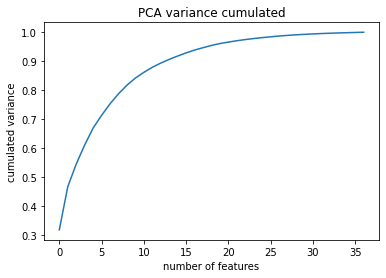

In [61]:
pca_ratio = pca.explained_variance_ratio_.cumsum()
plt.plot(pca_ratio)
plt.xlabel("number of features")
plt.ylabel("cumulated variance")
plt.title("PCA variance cumulated")

### Showing the explaination of the best component

Text(0.5, 1.0, 'the first component coefficients')

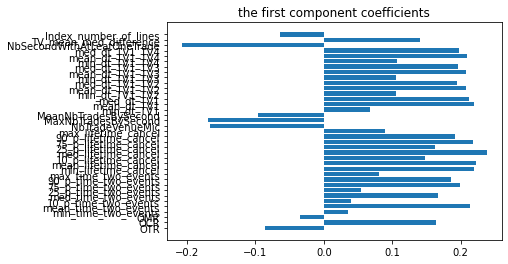

In [62]:
pca_0 = pca.components_[0]
pos = np.arange(37)
plt.barh(pos, pca_0,tick_label=train_X.columns[4:])
plt.title('the first component coefficients')

### Grid Search on Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [64]:
# Definition of the classifier
rf = RandomForestClassifier()

In [65]:
# Definition of the grid search
param_grid1 = {'n_estimators':[100,200], 'max_features':[6,8,12], 'max_depth':[15]}
grid_search = GridSearchCV(rf, param_grid1, cv=4)

In [66]:
y = train_df['type']
if GRIDSEARCH:
    grid_search.fit(X, y)

In [67]:
# Visualizing the results of the grid search
if GRIDSEARCH:
    grid_search.cv_results_

In [68]:
# Visualizing the results of the grid search
if GRIDSEARCH:
    print(grid_search.cv_results_)

In [69]:
# Selecting the best parameters (n_estimators=200, max_features=12, max_depth=15)
if GRIDSEARCH:
    print(grid_search.best_params_)

### Train and Test on labeled data

In [70]:
# Spliting dataset into train and test sets

from sklearn.model_selection import GroupShuffleSplit

gs = GroupShuffleSplit(n_splits=2, train_size=.7, random_state=42)
train_ix, test_ix = next(gs.split(train_X, y, groups=train_X.Trader))

X_train = train_X.loc[train_ix]
y_train = y.loc[train_ix]

X_test = train_X.loc[test_ix]
y_test = y.loc[test_ix]

#### Train

In [71]:
from sklearn.ensemble import RandomForestClassifier

# Defining the random forest with the best parameters found by Grid search

rf_clf = Pipeline([
                    ('preprocess', preprocess),
                    ('pca',pca),
                    ('clf', RandomForestClassifier(n_estimators=100, max_features=8, max_depth=15))
                  ])

In [72]:
if TRAIN_TEST:
    rf_clf.fit(X_train, y_train)

#### Test

In [73]:
# In this decision fonction : 
## a market player whose at least 85% of his rows are predicted as HFT is an HFT participant,
## a market player whose at least 50% of his rows are predicted as MIX is a MIX participant, 
## otherwise the model considers that the market player is a NON HFT.

# df should contain :
## a column called "Trader"
## a column called "type" which could be the real type or the types predicted for the market player

def decision(df):
    traders_list = np.unique(list(df['Trader']))
    traders_type = []
    for trader in traders_list:
        preds = list(df[df['Trader'] == trader]['type']) 
        non_hft = preds.count('NON HFT')
        mix = preds.count('MIX')
        hft = preds.count('HFT')
        rows = hft + non_hft + mix
        if hft/rows >= 0.85:
            traders_type.append('HFT')
        elif mix/rows >= 0.50:
            traders_type.append('MIX')
        else:
            traders_type.append('NON HFT')
    return pd.DataFrame({'Trader':traders_list, 'type':traders_type})

In [74]:
# Prediction
if TRAIN_TEST:
    y_pred = rf_clf.predict(X_test)

In [75]:
# Data
if TRAIN_TEST:
    pred_df = X_test['Trader'].to_frame()
    pred_df['type'] = y_pred

    real_df = X_test['Trader'].to_frame()
    real_df['type'] = y_test

In [76]:
if TRAIN_TEST:
    real_traders = decision(real_df)
    pred_traders = decision(pred_df)

#### Metrics

In [77]:
from sklearn import metrics

def micro_average_f1_score(dataframe_y_true, dataframe_y_pred):
    """
    Args
        dataframe_y_true: Pandas Dataframe
            Dataframe containing the true values of y.
            This dataframe was obtained by reading a csv file with following instruction:
            dataframe_y_true = pd.read_csv(CSV_1_FILE_PATH, index_col=0, sep=',')

        dataframe_y_pred: Pandas Dataframe
            This dataframe was obtained by reading a csv file with following instruction:
            dataframe_y_pred = pd.read_csv(CSV_2_FILE_PATH, index_col=0, sep=',')

    Returns
        score: Float
            The metric evaluated with the two dataframes. This must not be NaN.
    """

    score = metrics.f1_score(dataframe_y_true["type"], dataframe_y_pred["type"], average = "micro")

    return score

In [78]:
if TRAIN_TEST:
    print(micro_average_f1_score(real_traders, pred_traders))

In [79]:
# f1_score = 0.8076923076923077

### Train for submission

In [80]:
from sklearn.ensemble import RandomForestClassifier

# Defining the random forest with the best parameters found by Grid search

rf_clf = Pipeline([
                    ('preprocess', preprocess),
                    ('pca', pca),
                    ('clf', RandomForestClassifier(n_estimators=100, max_features=8, max_depth=15))
                  ])

In [81]:
if SUBMIT:
    start_time = time.time()
    rf_clf.fit(train_X, y)
    print("--- %s seconds ---" % (time.time() - start_time))

--- 88.41659736633301 seconds ---


In [82]:
if SUBMIT:
    pred_y = rf_clf.predict(test_X)

In [83]:
if SUBMIT:
    pred_df = test_X['Trader'].to_frame()
    pred_df['type'] = pred_y

In [84]:
if SUBMIT:
    pred_traders = decision(pred_df)

### Saving results

In [85]:
# Prediction result
if SUBMIT:
    pred_traders.to_csv('submission_files/AMF_test_Y_pca22_exploration.csv',index=False)

In [86]:
# Model

import pickle
if SUBMIT:
    pickle.dump(rf_clf['clf'], open('models/model_pca22_exploration', 'wb'))